# Pokemon Text Classification
Contributers: Katie Hu, Mendelina Lopez, Michael Nguyen

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import isnull
import config
import json
import requests
from collections import defaultdict, Counter
import time
import random
import os
import re
import emoji
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import joblib
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

### API Request
Source Documentation [https://pokeapi.co/docs/v2#pokemon, https://pokeapi.co/docs/v2#pokemon-colors]

The data being pulled using the pokemon api are the pokemon statistics and characteristics. 


In [2]:
# Pull data from url and confirm
api_url = "https://pokeapi.co/api/v2/pokemon/"
params = {"limit": "1281"} # The total amount of pokemon
pokemon_api = []
res = requests.request("GET", api_url, params=params)
data = res.json()
print("Pokemon and Pokemon APIs have been pulled")

# Create a list and API, then confirm
for pokemon in data["results"]:
    for k, v in pokemon.items():
        pokemon_api.append(v)
print("List of Pokemon and Pokemon API have been created")

Pokemon and Pokemon APIs have been pulled
List of Pokemon and Pokemon API have been created


In [3]:
# Separate Names and APIs into two lists
pokemon_name = pokemon_api[::2]
pokemon_API = pokemon_api[1::2]

# Merge into a Dictionary with Pokemon Names as 'key' and APIs as 'value'
pokemon_all = {}
for key in pokemon_name:
    for value in pokemon_API:
        pokemon_all[key] = value
        pokemon_API.remove(value)
        break
print("Dictionary of all Pokemon and their APIs has been created")

Dictionary of all Pokemon and their APIs has been created


In [4]:
# Check to see if there are 1281 pokemon

print("The number of pokemon called should be 1281: ", len(pokemon_all))

The number of pokemon called should be 1281:  1281


In [ ]:
# Dictionary set up for Pokemon Statistics

pokemon_data = defaultdict(list)

for pokemon, api in pokemon_all.items() :
    # request the page and sleep
    r = requests.request("GET", str(api))
    time.sleep(5 + 10*random.random())

    d = r.json()
    pokemon_data[pokemon].append(d)

In [5]:
# API to pull Pokemon Colors
color_api = "https://pokeapi.co/api/v2/pokemon-color/"
res1 = requests.request("GET", color_api)
colors = []
data1 = res1.json()
for color in data1["results"]:
    for k, v in color.items():
        colors.append(v)

# Separate Names and APIs into two lists
pokemon_color = colors[::2]
pokemon_color_API = colors[1::2]

In [6]:
# Merge into a Dictionary with Pokemon Colors as Key and APIs as Value

pokemon_colors = {}
for key in pokemon_color:
    for value in pokemon_color_API:
        pokemon_colors[key] = value
        pokemon_color_API.remove(value)
        break
print("Dictionary of All Pokemon Colors and Their APIs is: ", pokemon_colors)

Dictionary of All Pokemon Colors and Their APIs is:  {'black': 'https://pokeapi.co/api/v2/pokemon-color/1/', 'blue': 'https://pokeapi.co/api/v2/pokemon-color/2/', 'brown': 'https://pokeapi.co/api/v2/pokemon-color/3/', 'gray': 'https://pokeapi.co/api/v2/pokemon-color/4/', 'green': 'https://pokeapi.co/api/v2/pokemon-color/5/', 'pink': 'https://pokeapi.co/api/v2/pokemon-color/6/', 'purple': 'https://pokeapi.co/api/v2/pokemon-color/7/', 'red': 'https://pokeapi.co/api/v2/pokemon-color/8/', 'white': 'https://pokeapi.co/api/v2/pokemon-color/9/', 'yellow': 'https://pokeapi.co/api/v2/pokemon-color/10/'}


In [7]:
# Dictionary set up for Pokemon Colors

pokemon_colors_data = defaultdict(list)

for color, api in pokemon_colors.items() :
    # request the page and sleep
    r = requests.request("GET", str(api))
    time.sleep(5 + 10*random.random())

    d = r.json()
    pokemon_colors_data[color].append(d)

In [8]:
# Show the number of colors included

print(len(pokemon_colors_data))

10


We have decided to export Pokemon Statistics API data to a text file to store data as the API call took about 7.5 hours.

We will do the same for Pokemon Colors API data converting to a text file to store data. This API call time was approximately 2 minutes.

In [ ]:
# Export pokemon descirption data as a text file

with open('Pokemon_Data.txt', 'w') as Pokemon_Data:
     Pokemon_Data.write(json.dumps(pokemon_data))

In [10]:
# Export pokemon color data as a text file

with open('Pokemon_Colors.txt', 'w') as Pokemon_Colors:
     Pokemon_Colors.write(json.dumps(pokemon_colors_data))

### Load Data

In [11]:
# Load in pokemon description data and confirm the length

f = open('Pokemon_data.txt')
data = json.load(f)
print(len(data))

1281


In [12]:
# Load in pokemon color data and confirm the length

f1 = open('Pokemon_colors.txt')
data1 = json.load(f1)
print(len(data1))

10


### Data Ingestion and Pre-Processing

In [13]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {'''#{}[]'''}

# Stopwords
sw = stopwords.words("english")


# A function to show our descriptive statistics
def descriptive_stats(tokens, num_words = 5, verbose=True) :
    
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens).keys())
    lexical_diversity = round((num_unique_tokens/num_tokens),2) # Rounded to 2 Digits to match format
    num_characters = sum(len(i) for i in tokens)
    most_common = Counter(tokens).most_common(num_words)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The most common tokens are {most_common}.")
        
    return

# Removing URL's
def remove_URL(text):
    return re.sub(r"'url ' : 'http\S+", "", text)

# Remove stop words
def remove_stop(tokens) :
    tokens = [file for file in tokens if file not in sw]
    return(tokens)

# Remove unnecessary puncuation
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenize the given text
def tokenize(text) :  
    text = [file.lower().strip() for file in text.split()]
    return(text)

# Compile text into a pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    for transform in pipeline : 
        tokens = transform(tokens)
    return(tokens)

In [14]:
# Creating a list from the description dictionary including only the desired information

pokemon_list = []
for pokemon in data:
    for features in data[pokemon]:
        for feature, description in features.items():
            poke_dict = {'pokemon': pokemon, 'feature': feature, 'description': description}
            pokemon_list.append(poke_dict)

In [15]:
# Incorporating a pipeline that will lower case, remove url's, tokenize, and remove puncuation

my_pipeline = [str.lower,  remove_URL,tokenize, remove_punctuation, tokenize]
cleaned_data = []
for row in pokemon_list :
    text = " ".join(prepare(row, pipeline = my_pipeline))
    if text :
        cleaned_data.append(text)

In [19]:
df = pd.DataFrame.from_dict(pokemon_list)
df.head(20)

,pokemon,feature,description
0,bulbasaur,abilities,"[{'ability': {'name': 'overgrow', 'url': 'http..."
1,bulbasaur,base_experience,64
2,bulbasaur,forms,"[{'name': 'bulbasaur', 'url': 'https://pokeapi..."
3,bulbasaur,game_indices,"[{'game_index': 153, 'version': {'name': 'red'..."
4,bulbasaur,height,7
5,bulbasaur,held_items,[]
6,bulbasaur,id,1
7,bulbasaur,is_default,True
8,bulbasaur,location_area_encounters,https://pokeapi.co/api/v2/pokemon/1/encounters
9,bulbasaur,moves,"[{'move': {'name': 'razor-wind', 'url': 'https..."


The output above displays the first 20 records of the data including pokemon, feature, and description. We now need to condense the data removing features that are not important and showing all information on a pokemon along the same row.

In [22]:
# Transpose Dataframe for Pokemon Statistics

tdf = df.pivot(columns = 'feature', values = 'description', index = 'pokemon')
tdf.head(5)

feature,abilities,base_experience,forms,game_indices,height,held_items,id,is_default,location_area_encounters,moves,name,order,past_types,species,sprites,stats,types,weight
pokemon,,,,,,,,,,,,,,,,,,
abomasnow,"[{'ability': {'name': 'snow-warning', 'url': '...",173,"[{'name': 'abomasnow', 'url': 'https://pokeapi...","[{'game_index': 460, 'version': {'name': 'diam...",22,"[{'item': {'name': 'never-melt-ice', 'url': 'h...",460,True,https://pokeapi.co/api/v2/pokemon/460/encounters,"[{'move': {'name': 'mega-punch', 'url': 'https...",abomasnow,585,[],"{'name': 'abomasnow', 'url': 'https://pokeapi....",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 90, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1355
abomasnow-mega,"[{'ability': {'name': 'snow-warning', 'url': '...",208,"[{'name': 'abomasnow-mega', 'url': 'https://po...",[],27,"[{'item': {'name': 'never-melt-ice', 'url': 'h...",10060,False,https://pokeapi.co/api/v2/pokemon/10060/encoun...,"[{'move': {'name': 'ice-punch', 'url': 'https:...",abomasnow-mega,586,[],"{'name': 'abomasnow', 'url': 'https://pokeapi....","{'back_default': None, 'back_female': None, 'b...","[{'base_stat': 90, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1850
abra,"[{'ability': {'name': 'synchronize', 'url': 'h...",62,"[{'name': 'abra', 'url': 'https://pokeapi.co/a...","[{'game_index': 148, 'version': {'name': 'red'...",9,"[{'item': {'name': 'twisted-spoon', 'url': 'ht...",63,True,https://pokeapi.co/api/v2/pokemon/63/encounters,"[{'move': {'name': 'mega-punch', 'url': 'https...",abra,103,[],"{'name': 'abra', 'url': 'https://pokeapi.co/ap...",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 25, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'psychic', 'url'...",195
absol,"[{'ability': {'name': 'pressure', 'url': 'http...",163,"[{'name': 'absol', 'url': 'https://pokeapi.co/...","[{'game_index': 376, 'version': {'name': 'ruby...",12,"[{'item': {'name': 'life-orb', 'url': 'https:/...",359,True,https://pokeapi.co/api/v2/pokemon/359/encounters,"[{'move': {'name': 'scratch', 'url': 'https://...",absol,478,[],"{'name': 'absol', 'url': 'https://pokeapi.co/a...",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 65, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'dark', 'url': '...",470
absol-mega,"[{'ability': {'name': 'magic-bounce', 'url': '...",198,"[{'name': 'absol-mega', 'url': 'https://pokeap...",[],12,"[{'item': {'name': 'life-orb', 'url': 'https:/...",10057,False,https://pokeapi.co/api/v2/pokemon/10057/encoun...,"[{'move': {'name': 'scratch', 'url': 'https://...",absol-mega,479,[],"{'name': 'absol', 'url': 'https://pokeapi.co/a...","{'back_default': None, 'back_female': None, 'b...","[{'base_stat': 65, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'dark', 'url': '...",490


In [23]:
# Reset Index as ID for the dataframe

tdf.reset_index(inplace=True)
tdf.set_index('id', inplace = True)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 460 to 10120
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   pokemon                   1281 non-null   object
 1   abilities                 1281 non-null   object
 2   base_experience           1126 non-null   object
 3   forms                     1281 non-null   object
 4   game_indices              1281 non-null   object
 5   height                    1281 non-null   object
 6   held_items                1281 non-null   object
 7   is_default                1281 non-null   object
 8   location_area_encounters  1281 non-null   object
 9   moves                     1281 non-null   object
 10  name                      1281 non-null   object
 11  order                     1281 non-null   object
 12  past_types                1281 non-null   object
 13  species                   1281 non-null   object
 14  sprites                   

In [24]:
# Creating a list of the colors dictionary

pokemon_colors_list = []
for colors in data1:
    for features in data1[colors]:
        for feature, description in features.items():
            poke_dict1 = {'color': colors, 'features': feature, 'descriptions': description}
            pokemon_colors_list.append(poke_dict1)

In [25]:
# Transpose Dataframe

df1 = pd.DataFrame.from_dict(pokemon_colors_list)
cdf = df1.pivot(columns = 'features', values = 'descriptions', index = 'color')
cdf

features,id,name,names,pokemon_species
color,,,,
black,1,black,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'murkrow', 'url': 'https://pokeapi.c..."
blue,2,blue,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'squirtle', 'url': 'https://pokeapi...."
brown,3,brown,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'weedle', 'url': 'https://pokeapi.co..."
gray,4,gray,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'machop', 'url': 'https://pokeapi.co..."
green,5,green,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'bulbasaur', 'url': 'https://pokeapi..."
pink,6,pink,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'slowpoke', 'url': 'https://pokeapi...."
purple,7,purple,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'rattata', 'url': 'https://pokeapi.c..."
red,8,red,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'charmander', 'url': 'https://pokeap..."
white,9,white,"[{'language': {'name': 'ja-Hrkt', 'url': 'http...","[{'name': 'seel', 'url': 'https://pokeapi.co/a..."


In [26]:
# Drop Unnecessary Columns

cdf = cdf.drop(columns = ['id', 'names'])
cdf = cdf.reset_index(drop = True)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             10 non-null     object
 1   pokemon_species  10 non-null     object
dtypes: object(2)
memory usage: 292.0+ bytes


In [27]:
cdf

features,name,pokemon_species
0,black,"[{'name': 'murkrow', 'url': 'https://pokeapi.c..."
1,blue,"[{'name': 'squirtle', 'url': 'https://pokeapi...."
2,brown,"[{'name': 'weedle', 'url': 'https://pokeapi.co..."
3,gray,"[{'name': 'machop', 'url': 'https://pokeapi.co..."
4,green,"[{'name': 'bulbasaur', 'url': 'https://pokeapi..."
5,pink,"[{'name': 'slowpoke', 'url': 'https://pokeapi...."
6,purple,"[{'name': 'rattata', 'url': 'https://pokeapi.c..."
7,red,"[{'name': 'charmander', 'url': 'https://pokeap..."
8,white,"[{'name': 'seel', 'url': 'https://pokeapi.co/a..."
9,yellow,"[{'name': 'sandshrew', 'url': 'https://pokeapi..."


The above output is a dataframe that provides the color of each pokemon along with the url.

### Descriptive Statistics

In [28]:
# Dictionary
descriptive_stats(cleaned_data)

There are 23058 tokens in the data.
There are 23058 unique tokens in the data.
There are 139245926 characters in the data.
The lexical diversity is 1.000 in the data.
The most common tokens are [("{'pokemon':'bulbasaur','feature':'abilities','description':[{'ability':{'name':'overgrow','url':'https://pokeapi.co/api/v2/ability/65/'},'is_hidden':false,'slot':1},{'ability':{'name':'chlorophyll','url':'https://pokeapi.co/api/v2/ability/34/'},'is_hidden':true,'slot':3}]}", 1), ("{'pokemon':'bulbasaur','feature':'base_experience','description':64}", 1), ("{'pokemon':'bulbasaur','feature':'forms','description':[{'name':'bulbasaur','url':'https://pokeapi.co/api/v2/pokemon-form/1/'}]}", 1), ("{'pokemon':'bulbasaur','feature':'game_indices','description':[{'game_index':153,'version':{'name':'red','url':'https://pokeapi.co/api/v2/version/1/'}},{'game_index':153,'version':{'name':'blue','url':'https://pokeapi.co/api/v2/version/2/'}},{'game_index':153,'version':{'name':'yellow','url':'https://pokea

The descriptive statistics for the dictionary shows the same number of tokens and unique tokens (23058). That is with 139,245,926 characters in the data. The output shows a lexical diversity of 1.00 which is the ratio of unique words to the whole set. Given the output for the most common tokens, it is difficult to read and does not seem to truly reflect what our team is looking for.

In [29]:
# DataFrame
descriptive_stats(tdf)

There are 1281 tokens in the data.
There are 18 unique tokens in the data.
There are 152 characters in the data.
The lexical diversity is 0.010 in the data.
The most common tokens are [('pokemon', 1), ('abilities', 1), ('base_experience', 1), ('forms', 1), ('game_indices', 1)].


The descriptive statistics for the dataframe shows 1281 tokens which are the number of records, and 18 of those are unique. We are also provided with the fact that there are 152 characters in this data. The lexical diversity, or ratio of unique token to the whole text is 0.01 and is drastically different from the previous output. Looking at the most common tokens make sense given the type of data we are dealing with.

### Data Cleaning

`Moves`, `Abilities`, and `Types` features have a list of dictionaries within each pokemon type. For getting it ready to model, cleaning is done to separate out the data to have a list of terms.


In [31]:
tdf.head()

feature,pokemon,abilities,base_experience,forms,game_indices,height,held_items,is_default,location_area_encounters,moves,name,order,past_types,species,sprites,stats,types,weight
id,,,,,,,,,,,,,,,,,,
460,abomasnow,"[{'ability': {'name': 'snow-warning', 'url': '...",173,"[{'name': 'abomasnow', 'url': 'https://pokeapi...","[{'game_index': 460, 'version': {'name': 'diam...",22,"[{'item': {'name': 'never-melt-ice', 'url': 'h...",True,https://pokeapi.co/api/v2/pokemon/460/encounters,"[{'move': {'name': 'mega-punch', 'url': 'https...",abomasnow,585,[],"{'name': 'abomasnow', 'url': 'https://pokeapi....",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 90, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1355
10060,abomasnow-mega,"[{'ability': {'name': 'snow-warning', 'url': '...",208,"[{'name': 'abomasnow-mega', 'url': 'https://po...",[],27,"[{'item': {'name': 'never-melt-ice', 'url': 'h...",False,https://pokeapi.co/api/v2/pokemon/10060/encoun...,"[{'move': {'name': 'ice-punch', 'url': 'https:...",abomasnow-mega,586,[],"{'name': 'abomasnow', 'url': 'https://pokeapi....","{'back_default': None, 'back_female': None, 'b...","[{'base_stat': 90, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1850
63,abra,"[{'ability': {'name': 'synchronize', 'url': 'h...",62,"[{'name': 'abra', 'url': 'https://pokeapi.co/a...","[{'game_index': 148, 'version': {'name': 'red'...",9,"[{'item': {'name': 'twisted-spoon', 'url': 'ht...",True,https://pokeapi.co/api/v2/pokemon/63/encounters,"[{'move': {'name': 'mega-punch', 'url': 'https...",abra,103,[],"{'name': 'abra', 'url': 'https://pokeapi.co/ap...",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 25, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'psychic', 'url'...",195
359,absol,"[{'ability': {'name': 'pressure', 'url': 'http...",163,"[{'name': 'absol', 'url': 'https://pokeapi.co/...","[{'game_index': 376, 'version': {'name': 'ruby...",12,"[{'item': {'name': 'life-orb', 'url': 'https:/...",True,https://pokeapi.co/api/v2/pokemon/359/encounters,"[{'move': {'name': 'scratch', 'url': 'https://...",absol,478,[],"{'name': 'absol', 'url': 'https://pokeapi.co/a...",{'back_default': 'https://raw.githubuserconten...,"[{'base_stat': 65, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'dark', 'url': '...",470
10057,absol-mega,"[{'ability': {'name': 'magic-bounce', 'url': '...",198,"[{'name': 'absol-mega', 'url': 'https://pokeap...",[],12,"[{'item': {'name': 'life-orb', 'url': 'https:/...",False,https://pokeapi.co/api/v2/pokemon/10057/encoun...,"[{'move': {'name': 'scratch', 'url': 'https://...",absol-mega,479,[],"{'name': 'absol', 'url': 'https://pokeapi.co/a...","{'back_default': None, 'back_female': None, 'b...","[{'base_stat': 65, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'dark', 'url': '...",490


Clean dictionary of Types into list of Types

In [32]:
pokemon_types = []
for val in tdf['types']:
    res = [sub['type'] for sub in val] # list of dictionaries of types
    results = [sub['name'] for sub in res] # Woo! Output of types
    pokemon_types.append(results)

In [35]:
# Create a dataframe that only shows the type names

types_df = pd.DataFrame(columns = ["types"])
poke_types = []
for row in pokemon_types[:1281]:
    row_dict = {'types': row}
    poke_types.append(row_dict)

types_df = pd.DataFrame.from_dict(poke_types)
types_df.reset_index(drop=True).head(20) # Show the first few pokemon types

,types
0,"[grass, ice]"
1,"[grass, ice]"
2,[psychic]
3,[dark]
4,[dark]
5,[bug]
6,"[steel, ghost]"
7,"[steel, ghost]"
8,"[rock, flying]"
9,"[rock, flying]"


Clean the abilities column from a list of dictionaries into a list of just abilities

In [36]:
pokemon_abilities = []
for val in tdf['abilities']:
    res = [sub['ability'] for sub in val] # list of dictionaries of abilities
    results = [sub['name'] for sub in res] # Woo! Output of abilities
    pokemon_abilities.append(results)

In [38]:
abilities_df = pd.DataFrame(columns = ["abilities"])
poke_abilities = []
for row in pokemon_abilities[:1281]:
    row_dict = {'abilities': row}
    poke_abilities.append(row_dict)

abilities_df = pd.DataFrame.from_dict(poke_abilities)
abilities_df.reset_index(drop=True).head(20) # Show the first few pokemon abilities

,abilities
0,"[snow-warning, soundproof]"
1,[snow-warning]
2,"[synchronize, inner-focus, magic-guard]"
3,"[pressure, super-luck, justified]"
4,[magic-bounce]
5,"[hydration, sticky-hold, unburden]"
6,[stance-change]
7,[stance-change]
8,"[rock-head, pressure, unnerve]"
9,[tough-claws]


Drop Old Abilities Column to prepare for Cleaned Abilities to Dataframe

In [39]:
tdf = tdf.drop(columns=['abilities'])

Clean dictionary of moves into list of moves

In [40]:
pokemon_moves = []
for val in tdf['moves']:
    res = [sub['move'] for sub in val] # list of dictionaries of moves
    results = [sub['name'] for sub in res] # Woo! Output of Moves
    pokemon_moves.append(results)

In [41]:
moves_df = pd.DataFrame(columns = ["moves"])
poke_moves = []
for row in pokemon_moves[:1281]:
    row_dict = {'moves': row}
    poke_moves.append(row_dict)

moves_df = pd.DataFrame.from_dict(poke_moves)
moves_df.reset_index(drop=True).head(20) # Show the first few pokemon moves

,moves
0,"[mega-punch, ice-punch, swords-dance, mega-kic..."
1,"[ice-punch, swords-dance, leer, mist, ice-beam..."
2,"[mega-punch, fire-punch, ice-punch, thunder-pu..."
3,"[scratch, razor-wind, swords-dance, cut, headb..."
4,"[scratch, razor-wind, swords-dance, cut, doubl..."
5,"[body-slam, acid, hyper-beam, absorb, mega-dra..."
6,"[swords-dance, cut, tackle, hyper-beam, toxic,..."
7,"[swords-dance, cut, tackle, hyper-beam, toxic,..."
8,"[razor-wind, wing-attack, whirlwind, fly, head..."
9,"[wing-attack, whirlwind, fly, headbutt, take-d..."


Clean Game Indices

In [42]:
pokemon_game = []
for val in tdf['game_indices']:
    res = [sub['version'] for sub in val] # list of dictionaries of game indices
    results = [sub['name'] for sub in res] # Woo! Output of game indices
    pokemon_game.append(results)

In [43]:
game_df = pd.DataFrame(columns = ["pokemon_games"])
poke_game = []
for row in pokemon_game[:1281]:
    row_dict = {'pokemon_games': row}
    poke_game.append(row_dict)

game_df = pd.DataFrame.from_dict(poke_game)
game_df.reset_index(drop=True).head(20) # Show the first few game indices

,pokemon_games
0,"[diamond, pearl, platinum, heartgold, soulsilv..."
1,[]
2,"[red, blue, yellow, gold, silver, crystal, rub..."
3,"[ruby, sapphire, emerald, firered, leafgreen, ..."
4,[]
5,"[black, white, black-2, white-2]"
6,[]
7,[]
8,"[red, blue, yellow, gold, silver, crystal, rub..."
9,[]


In [44]:
# Resetting the index

tdf = tdf.reset_index(drop=True)

In [48]:
# Combining the columns into one dataframe

clean_df = pd.merge(tdf, abilities_df, left_index = True, right_index = True)
clean_df = clean_df.drop(columns=['moves', 'types', 'game_indices'])
clean_df = pd.merge(clean_df, moves_df, left_index = True, right_index = True)
clean_df = pd.merge(clean_df, types_df, left_index = True, right_index = True)
clean_df = pd.merge(clean_df, game_df, left_index = True, right_index = True)

In [49]:
# Dropping the unnecessary columns

clean_df = clean_df.drop(columns=['forms', 'held_items', 'is_default', 'location_area_encounters', 'past_types', 'species', 'sprites', 'stats'])
clean_df.head(20)

,pokemon,base_experience,height,name,order,weight,abilities,moves,types,pokemon_games
0,abomasnow,173,22,abomasnow,585,1355,"[snow-warning, soundproof]","[mega-punch, ice-punch, swords-dance, mega-kic...","[grass, ice]","[diamond, pearl, platinum, heartgold, soulsilv..."
1,abomasnow-mega,208,27,abomasnow-mega,586,1850,[snow-warning],"[ice-punch, swords-dance, leer, mist, ice-beam...","[grass, ice]",[]
2,abra,62,9,abra,103,195,"[synchronize, inner-focus, magic-guard]","[mega-punch, fire-punch, ice-punch, thunder-pu...",[psychic],"[red, blue, yellow, gold, silver, crystal, rub..."
3,absol,163,12,absol,478,470,"[pressure, super-luck, justified]","[scratch, razor-wind, swords-dance, cut, headb...",[dark],"[ruby, sapphire, emerald, firered, leafgreen, ..."
4,absol-mega,198,12,absol-mega,479,490,[magic-bounce],"[scratch, razor-wind, swords-dance, cut, doubl...",[dark],[]
5,accelgor,173,8,accelgor,739,253,"[hydration, sticky-hold, unburden]","[body-slam, acid, hyper-beam, absorb, mega-dra...",[bug],"[black, white, black-2, white-2]"
6,aegislash-blade,250,17,aegislash-blade,816,530,[stance-change],"[swords-dance, cut, tackle, hyper-beam, toxic,...","[steel, ghost]",[]
7,aegislash-shield,250,17,aegislash-shield,815,530,[stance-change],"[swords-dance, cut, tackle, hyper-beam, toxic,...","[steel, ghost]",[]
8,aerodactyl,180,18,aerodactyl,232,590,"[rock-head, pressure, unnerve]","[razor-wind, wing-attack, whirlwind, fly, head...","[rock, flying]","[red, blue, yellow, gold, silver, crystal, rub..."
9,aerodactyl-mega,215,21,aerodactyl-mega,233,790,[tough-claws],"[wing-attack, whirlwind, fly, headbutt, take-d...","[rock, flying]",[]


In [50]:
clean_df = clean_df.drop(columns = ['pokemon_games']) # Dropped since too many empty lists.

#### Cleaning of Pokemon Colors and Species

In [51]:
# Creating a list of pokemon species

pokemon = []
for val in cdf['pokemon_species']:
    res = [sub['name'] for sub in val]
    pokemon.append(res)

In [52]:
# Setting the colors to as a column

black = pokemon[0]
blue = pokemon[1]
brown = pokemon[2]
gray = pokemon[3] 
green = pokemon[4]
pink = pokemon[5]
purple = pokemon[6]
red = pokemon[7]
white = pokemon[8]
yellow = pokemon[9]

In [53]:
# Creating a dataframe that gives the colors of each pokemon

pokemon_colors=pd.DataFrame((list(zip(black, blue, brown, gray, green, pink, purple, red, white, yellow))), 
                            columns=['black', 'blue', 'brown', 'gray', 'green', 'pink', 'purple', 'red', 'white', 'yellow'])
pokemon_colors

,black,blue,brown,gray,green,pink,purple,red,white,yellow
0,murkrow,squirtle,weedle,machop,bulbasaur,slowpoke,rattata,charmander,seel,sandshrew
1,unown,nidoran-f,pidgey,magnemite,caterpie,exeggcute,ekans,paras,togepi,meowth
2,sneasel,oddish,spearow,onix,bellsprout,lickitung,nidoran-m,krabby,mareep,psyduck
3,houndour,poliwag,vulpix,rhyhorn,scyther,porygon,zubat,voltorb,smeargle,ponyta
4,mawile,tentacool,diglett,misdreavus,chikorita,mew,venonat,goldeen,lugia,drowzee
5,spoink,tangela,mankey,pineco,spinarak,cleffa,grimer,magikarp,wingull,zapdos
6,seviper,horsea,growlithe,qwilfish,natu,igglybuff,shellder,ledyba,ralts,moltres
7,shuppet,lapras,abra,remoraid,larvitar,hoppip,gastly,yanma,zangoose,cyndaquil
8,duskull,omanyte,geodude,skarmory,celebi,snubbull,koffing,slugma,absol,pichu
9,chatot,articuno,farfetchd,poochyena,treecko,corsola,ditto,delibird,pachirisu,sunkern


In [54]:
# Transform Pokemon Colors Dataframe to have two columns -> pokemon and color

pokemon_colors = pokemon_colors.reset_index(inplace = False)

pc_df = pokemon_colors.melt(id_vars='index', var_name='color', value_name='pokemon')
print(pc_df.sample(5)) # Check to ensure that the melt was done correctly and colors still match with the pokemon

     index   color     pokemon
3        3   black    houndour
129     33   brown    regirock
318     30  purple  crabrawler
469     37  yellow     zeraora
197      5   green    spinarak


Merge Pokemon Colors to Pokemon Statistics Dataframe

In [55]:
final_df = pd.merge(clean_df, pc_df, on = 'pokemon')

In [57]:
clean_df.head()

,pokemon,base_experience,height,name,order,weight,abilities,moves,types
0,abomasnow,173,22,abomasnow,585,1355,"[snow-warning, soundproof]","[mega-punch, ice-punch, swords-dance, mega-kic...","[grass, ice]"
1,abomasnow-mega,208,27,abomasnow-mega,586,1850,[snow-warning],"[ice-punch, swords-dance, leer, mist, ice-beam...","[grass, ice]"
2,abra,62,9,abra,103,195,"[synchronize, inner-focus, magic-guard]","[mega-punch, fire-punch, ice-punch, thunder-pu...",[psychic]
3,absol,163,12,absol,478,470,"[pressure, super-luck, justified]","[scratch, razor-wind, swords-dance, cut, headb...",[dark]
4,absol-mega,198,12,absol-mega,479,490,[magic-bounce],"[scratch, razor-wind, swords-dance, cut, doubl...",[dark]


In [58]:
# Set the cleaned data set to csv

clean_df.to_csv('Cleaned_Data_No_Colors.csv')

In [59]:
# Read in the cleaned data csv file

clean_df = pd.read_csv('Cleaned_Data_No_Colors.csv', index_col = [0])

In [60]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 0 to 1280
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pokemon          1281 non-null   object 
 1   base_experience  1126 non-null   float64
 2   height           1281 non-null   int64  
 3   name             1281 non-null   object 
 4   order            1281 non-null   int64  
 5   weight           1281 non-null   int64  
 6   abilities        1281 non-null   object 
 7   moves            1281 non-null   object 
 8   types            1281 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 100.1+ KB


In [61]:
# Drop Missing Data and Remove Brackets

clean_df = clean_df.dropna()

clean_df['abilities'] = clean_df['abilities'].apply(lambda x: x[1:-1])
clean_df['moves'] = clean_df['moves'].apply(lambda x: x[1:-1])
clean_df['types'] = clean_df['types'].apply(lambda x: x[1:-1])


In [62]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1126 entries, 0 to 1280
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pokemon          1126 non-null   object 
 1   base_experience  1126 non-null   float64
 2   height           1126 non-null   int64  
 3   name             1126 non-null   object 
 4   order            1126 non-null   int64  
 5   weight           1126 non-null   int64  
 6   abilities        1126 non-null   object 
 7   moves            1126 non-null   object 
 8   types            1126 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 88.0+ KB


In [63]:
# Set the cleaned set with missing data dropped to csv

clean_df.to_csv('Final_Data.csv')

In [65]:
clean_df.head()

,pokemon,base_experience,height,name,order,weight,abilities,moves,types
0,abomasnow,173.0,22,abomasnow,585,1355,"'snow-warning', 'soundproof'","'mega-punch', 'ice-punch', 'swords-dance', 'me...","'grass', 'ice'"
1,abomasnow-mega,208.0,27,abomasnow-mega,586,1850,'snow-warning',"'ice-punch', 'swords-dance', 'leer', 'mist', '...","'grass', 'ice'"
2,abra,62.0,9,abra,103,195,"'synchronize', 'inner-focus', 'magic-guard'","'mega-punch', 'fire-punch', 'ice-punch', 'thun...",'psychic'
3,absol,163.0,12,absol,478,470,"'pressure', 'super-luck', 'justified'","'scratch', 'razor-wind', 'swords-dance', 'cut'...",'dark'
4,absol-mega,198.0,12,absol-mega,479,490,'magic-bounce',"'scratch', 'razor-wind', 'swords-dance', 'cut'...",'dark'


In [66]:
# Show the different types of pokemon

y_df = clean_df['types']
print(y_df.unique())

["'grass', 'ice'" "'psychic'" "'dark'" "'bug'" "'steel', 'ghost'"
 "'rock', 'flying'" "'steel', 'rock'" "'steel'" "'normal'" "'fairy'"
 "'water'" "'dragon', 'flying'" "'dragon', 'fairy'" "'rock', 'ice'"
 "'grass', 'poison'" "'electric'" "'electric', 'dragon'" "'rock', 'bug'"
 "'grass', 'dragon'" "'water', 'bug'" "'poison'" "'fire'" "'water', 'ice'"
 "'electric', 'ice'" "'bug', 'poison'" "'ice', 'flying'"
 "'psychic', 'flying'" "'normal', 'fairy'" "'ice'" "'dragon'"
 "'water', 'fairy'" "'ground', 'psychic'" "'ghost'" "'rock', 'water'"
 "'water', 'ground'" "'rock', 'steel'" "'grass'" "'bug', 'flying'"
 "'steel', 'psychic'" "'normal', 'fighting'" "'normal', 'water'"
 "'dark', 'steel'" "'fire', 'ghost'" "'fire', 'fighting'" "'rock'"
 "'normal', 'flying'" "'grass', 'fighting'" "'water', 'psychic'"
 "'bug', 'fighting'" "'grass', 'dark'" "'psychic', 'grass'"
 "'psychic', 'ice'" "'psychic', 'ghost'" "'fire', 'ground'"
 "'rock', 'fairy'" "'rock', 'fire'" "'water', 'rock'" "'water', 'dark'"
 "'s

In [67]:
# set aside the types column

y_df = y_df.to_frame()

In [68]:
# Get the tokens and number of tokens

y_df['tokens'] = y_df['types'].apply(prepare, pipeline = my_pipeline)
y_df['num_tokens'] = y_df['tokens'].map(len) 

In [69]:
types_corpus = [x for y in y_df['tokens'] for x in y]

In [70]:
# Most Common Pokemon Types 

tc = Counter(types_corpus)

for k, v in tc.most_common(5):
    print('%s: %i' % (k, v))

'normal': 75
'water': 75
'electric': 49
'psychic': 45
'grass': 45


The most common types of pokemon seem to be between 'normal' and 'water'.

### Build Corpora and Word Clouds

In [71]:
# Combine all text into one large corpus
clean_df['corpus'] = clean_df[['pokemon','abilities', 'moves','types']].agg(' '.join, axis = 1)

In [72]:
# Apply the pipeline to the cleaned dataframe

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

clean_df['tokens'] = clean_df['corpus'].apply(prepare,pipeline=my_pipeline)
clean_df['num_tokens'] = clean_df['tokens'].map(len) 

In [73]:
# Dropping the columns that do not include words

cleantext_df = clean_df
cleantext_df = cleantext_df.drop(columns = ['base_experience', 'height', 'order', 'weight'])

In [76]:
pokemon_corpus = [x for y in clean_df['tokens'] for x in y]

In [77]:
# Most common words

pc = Counter(pokemon_corpus)

for k, v in pc.most_common(10):
    print('%s: %i' % (k, v))

snore: 1070
protect: 1070
substitute: 1068
rest: 1067
sleeptalk: 1067
round: 1065
facade: 1063
endure: 958
swagger: 954
toxic: 951


The most common words within this dataset consisting only of text seems to be between 'snore' and 'protect'.

In [78]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if sw is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in sw}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [79]:
word_count = count_words(cleantext_df)

Pokemon Word Cloud


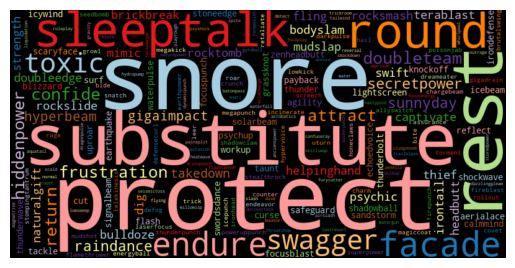

In [80]:
# Build Word Clouds for Corpus

print('''Pokemon Word Cloud''')
wordcloud(word_count.freq)

It is interesting to note that the most common words seem to be between 'snore', 'substitute', and 'protect'. In many ways 'snore' and 'protect' might have complete opposite uses, but in this case, they are equally as important.

### Modeling

In [82]:
# Set our final data set to a csv file

Final_Data = pd.read_csv('Final_Data.csv', index_col = [0])
Final_Data.head()

,pokemon,base_experience,height,name,order,weight,abilities,moves,types
0,abomasnow,173.0,22,abomasnow,585,1355,"'snow-warning', 'soundproof'","'mega-punch', 'ice-punch', 'swords-dance', 'me...","'grass', 'ice'"
1,abomasnow-mega,208.0,27,abomasnow-mega,586,1850,'snow-warning',"'ice-punch', 'swords-dance', 'leer', 'mist', '...","'grass', 'ice'"
2,abra,62.0,9,abra,103,195,"'synchronize', 'inner-focus', 'magic-guard'","'mega-punch', 'fire-punch', 'ice-punch', 'thun...",'psychic'
3,absol,163.0,12,absol,478,470,"'pressure', 'super-luck', 'justified'","'scratch', 'razor-wind', 'swords-dance', 'cut'...",'dark'
4,absol-mega,198.0,12,absol-mega,479,490,'magic-bounce',"'scratch', 'razor-wind', 'swords-dance', 'cut'...",'dark'


Random Forest Multi-Label Classifier

In [85]:
pokemon_data_encoded = Final_Data.copy()

# MultiLabelBinarizer encode 'abilities'
mlb_abilities = MultiLabelBinarizer()
abilities_encoded = mlb_abilities.fit_transform(pokemon_data_encoded['abilities'])
abilities_encoded_df = pd.DataFrame(abilities_encoded, columns=mlb_abilities.classes_)
pokemon_data_encoded = pd.concat([pokemon_data_encoded.drop('abilities', axis=1), abilities_encoded_df], axis=1)

# Separate features from the target
X = pokemon_data_encoded.drop('types', axis=1)  
y = Final_Data['types']  

# MultiLabelBinarizer encode 'types'
mlb_types = MultiLabelBinarizer()
y_encoded = mlb_types.fit_transform(y)

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# One hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align 
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Handle NaN 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# RFC
clf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

# Get best estimator
best_clf = grid_search.best_estimator_

# Predictions
y_pred = best_clf.predict(X_test)

# Print
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       127
           1       1.00      1.00      1.00       226
           2       0.83      0.69      0.75       127
           3       0.78      0.92      0.85       117
           4       1.00      0.05      0.10        19
           5       0.86      0.30      0.45        79
           6       1.00      0.13      0.23        38
           7       0.83      0.63      0.71        91
           8       0.82      0.39      0.53        69
           9       0.83      0.74      0.78       121
          10       0.89      0.26      0.41        61
          11       0.84      0.88      0.86       141
          12       1.00      0.18      0.30        28
          13       0.84      0.44      0.57        71
          14       1.00      0.43      0.60        21
          15       0.75      0.80      0.78        96
          16      

'Moves' will be added to encoding to enhance features

In [87]:
pokemon_data_encoded = Final_Data.copy()

# Handle missing 'moves' data
pokemon_data_encoded['moves'] = pokemon_data_encoded['moves'].apply(lambda x: x if isinstance(x, list) else [])

# MultiLabelBinarizer encode 'abilities'
mlb_abilities = MultiLabelBinarizer()
abilities_encoded = mlb_abilities.fit_transform(pokemon_data_encoded['abilities'])
abilities_encoded_df = pd.DataFrame(abilities_encoded, columns=mlb_abilities.classes_)
pokemon_data_encoded = pd.concat([pokemon_data_encoded.drop('abilities', axis=1), abilities_encoded_df], axis=1)

# MultiLabelBinarizer encode 'moves'
mlb_moves = MultiLabelBinarizer()
moves_encoded = mlb_moves.fit_transform(pokemon_data_encoded['moves'])
moves_encoded_df = pd.DataFrame(moves_encoded, columns=mlb_moves.classes_)
pokemon_data_encoded = pd.concat([pokemon_data_encoded.drop('moves', axis=1), moves_encoded_df], axis=1)

# Separate features from the target
X = pokemon_data_encoded.drop('types', axis=1)  
y = Final_Data['types']  

# MultiLabelBinarizer encode 'types'
mlb_types = MultiLabelBinarizer()
y_encoded = mlb_types.fit_transform(y)

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# One hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align 
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Handle NaN 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# RFC
clf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

# Get best estimator
best_clf = grid_search.best_estimator_

# Predictions
y_pred = best_clf.predict(X_test)

# Print
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       127
           1       1.00      1.00      1.00       226
           2       0.82      0.71      0.76       127
           3       0.80      0.92      0.86       117
           4       1.00      0.16      0.27        19
           5       0.86      0.32      0.46        79
           6       0.89      0.21      0.34        38
           7       0.79      0.62      0.69        91
           8       0.82      0.45      0.58        69
           9       0.85      0.79      0.82       121
          10       0.90      0.30      0.44        61
          11       0.84      0.90      0.87       141
          12       1.00      0.21      0.35        28
          13       0.92      0.46      0.62        71
          14       1.00      0.43      0.60        21
          15       0.74      0.79      0.76        96
          16      

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.24336283185840707

It should be noted that the above model gives an accuracy score of 0.24. Further study might want to try other types of predictive modeling for optimum metric scores.

___________________________

### Creation of Flask App

In [89]:
import joblib
joblib.dump(clf, 'Pokemon_model.pkl')

['Pokemon_model.pkl']

In [90]:
Pokemon_model = open('Pokemon_model.pkl','rb')
clf_model = joblib.load(Pokemon_model)

Testing of other model methods

### Return Pokemon Data Feature


In [91]:
# Request an input for the pokemon name

pokemon_request = input("Enter Pokemon Name: ")

Enter Pokemon Name: abra


In [92]:
# Gives what was inputted

pokemon_request

'abra'

In [95]:
# The output is the complete record of information for that specified pokemon

pokemon_output = Final_Data.loc[Final_Data['pokemon'] == pokemon_request]
pokemon_output

,Unnamed: 0,pokemon,base_experience,height,name,order,weight,abilities,moves,types
2,2,abra,62.0,9,abra,103,195,"'synchronize', 'inner-focus', 'magic-guard'","'mega-punch', 'fire-punch', 'ice-punch', 'thun...",'psychic'


### Recommendations on Next Steps

The app is meant to make a prediction on pokemon types based on information provided. For next steps, further work could be done to get the model to make such predictions and be reflected in the app. It might also be interesting to add to the app so that the user is able to list different features other than 'type' for the app to predict. The application could possibly predict another feature. If additional data were provided, it might also be interesting to build an app that can predict the personality of the user based on their favorite pokemon features.